# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow import lite
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, GlobalMaxPooling1D, Flatten, Dropout, BatchNormalization, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading and Preprocessing

In [ ]:
# Change the path according to the location of your CSV file
file_path = '/content/drive/MyDrive/Dataset for Capstone/dataset_full_new_58k.csv'

# Read data from a csv file and create a DataFrame
df_first = pd.read_csv(file_path, sep=';', encoding='latin1')
df_first = df_first.rename(columns={'Column1': 'Label', 'Column2': 'Text'})

# Display the first few rows of the DataFrame
df_first.head()

,Label,Text
0,anxiety,Apakah ada orang lain yang suka berjalan-jalan...
1,anxiety,"Meditasi membuat saya cemas, saya melakukan be..."
2,anxiety,Kata-kata kasar tentang obat-obatan kecemasan-...
3,anxiety,Beberapa saran untuk teman saya? Saya berkenca...
4,anxiety,Merasa seperti saya kembali ke tempat saya mul...


In [ ]:
print('Number of row : ', df_first.shape[0])
print('Number of column : ', df_first.shape[1])

Number of row :  58044
Number of column :  2


In [ ]:
df_first.isnull().sum()

Label    0
Text     4
dtype: int64

In [ ]:
# Delete rows with null or NaN values from the DataFrame
df_first = df_first.dropna()

In [ ]:
df_first.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58040 entries, 0 to 58043
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   58040 non-null  object
 1   Text    58040 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [ ]:
df_first.duplicated().sum()

0

In [ ]:
df_first.Label.value_counts()

anxiety       19997
depression    19995
stress        18048
Name: Label, dtype: int64

# Text Preprocessing and Data Preparation

In [ ]:
vocab_size = 5000
embedding_dim = 64
max_length = 250
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Divide the data into training (80%), validation (10%), and test (10%)
training_sentences, temp_sentences, training_labels, temp_labels = train_test_split(df_first['Text'], df_first['Label'], train_size=0.8, shuffle=True)
# Split validation and test data (50% of remaining data each)
validation_sentences, test_sentences, validation_labels, test_labels = train_test_split(temp_sentences, temp_labels, train_size=0.5, shuffle=True)

In [ ]:
# Fit your tokenizer with training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

# Convert text to sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Pad sequences
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type,truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# Tokenizer to encode label.
label_tokenizer = LabelEncoder()
label_tokenizer.fit(df_first['Label'])

# Encode labels using label tokenizer
training_label_seq = np.array(label_tokenizer.transform(training_labels))
validation_label_seq = np.array(label_tokenizer.transform(validation_labels))
testing_label_seq = np.array(label_tokenizer.transform(test_labels))

# Model Building and Training

In [ ]:
def learning_rate_scheduler(epoch):
  return 0.0001

lr_scheduler= LearningRateScheduler(learning_rate_scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Create the embedding layer
embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length)

# Bidirectional LSTM
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(128)))
model.add(Flatten())
model.add(Dropout(0.5))

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Make sure you are using "sparse_categorical_crossentropy" as a loss fuction
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# history= model.fit(training_padded, training_label_seq, epochs=20,validation_data=(validation_padded, validation_label_seq),
#                  callbacks=[early_stopping, lr_scheduler])
history= model.fit(training_padded, training_label_seq, epochs=7,validation_data=(validation_padded, validation_label_seq))

Epoch 1/7
1451/1451 [==============================] - 101s 65ms/step - loss: 0.4885 - accuracy: 0.8079 - val_loss: 0.3992 - val_accuracy: 0.8468
Epoch 2/7
1451/1451 [==============================] - 40s 28ms/step - loss: 0.3510 - accuracy: 0.8722 - val_loss: 0.3849 - val_accuracy: 0.8579
Epoch 3/7
1451/1451 [==============================] - 35s 24ms/step - loss: 0.3088 - accuracy: 0.8877 - val_loss: 0.3889 - val_accuracy: 0.8542
Epoch 4/7
1451/1451 [==============================] - 39s 27ms/step - loss: 0.2788 - accuracy: 0.8997 - val_loss: 0.3764 - val_accuracy: 0.8568
Epoch 5/7
1451/1451 [==============================] - 34s 23ms/step - loss: 0.2519 - accuracy: 0.9098 - val_loss: 0.4108 - val_accuracy: 0.8570
Epoch 6/7
1451/1451 [==============================] - 32s 22ms/step - loss: 0.2294 - accuracy: 0.9187 - val_loss: 0.4364 - val_accuracy: 0.8535
Epoch 7/7
1451/1451 [==============================] - 33s 22ms/step - loss: 0.2031 - accuracy: 0.9281 - val_loss: 0.4434 - val_a

# Model Evaluation and Prediction

In [ ]:
# Model evaluation using test data
evaluation_results = model.evaluate(test_padded, testing_label_seq)

# Display evaluation results
print("Loss:", evaluation_results[0])
print("Accuracy:", evaluation_results[1])

182/182 [==============================] - 2s 9ms/step - loss: 0.4235 - accuracy: 0.8647
Loss: 0.4235190749168396
Accuracy: 0.864748477935791


In [ ]:
# Describes the new data to be predicted
new_data = ["aku stress menjalankan dunia ini"]

# Pre-processing of new data, including tokenization and padding
new_sequences = tokenizer.texts_to_sequences(new_data)
new_padded = pad_sequences(new_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Make predictions using the model
predictions = model.predict(new_padded)

# Display the prediction result
for i, text in enumerate(new_data):
    print(f"Text: {text}")

    # Displays the probability for each category
    for j, category in enumerate(label_tokenizer.classes_):
        probability = predictions[i][j] * 100
        print(f"{category} Probability: {probability:.2f}%")

    # Determine the category with the highest probability as the prediction
    predicted_class = label_tokenizer.classes_[np.argmax(predictions[i])]
    print(f"Predicted Class: {predicted_class}")

    # Added if-else logic to display statements based on predictions
    if predicted_class == 'anxiety' and predictions[i][1] > 0.5:
        print("Model predicts high probability of anxiety.")
    elif predicted_class == 'depression' and predictions[i][2] > 0.5:
        print("Model predicts high probability of depression.")
    elif predicted_class == 'stress' and predictions[i][0] > 0.5:
        print("Model predicts high probability of stress.")
    else:
        print("Model predicts other mental health condition.")

1/1 [==============================] - 1s 932ms/step
Text: aku stress menjalankan dunia ini
anxiety Probability: 2.80%
depression Probability: 6.12%
stress Probability: 91.09%
Predicted Class: stress
Model predicts other mental health condition.


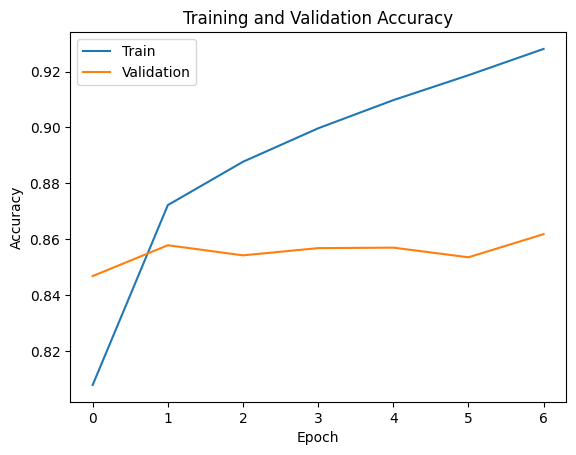

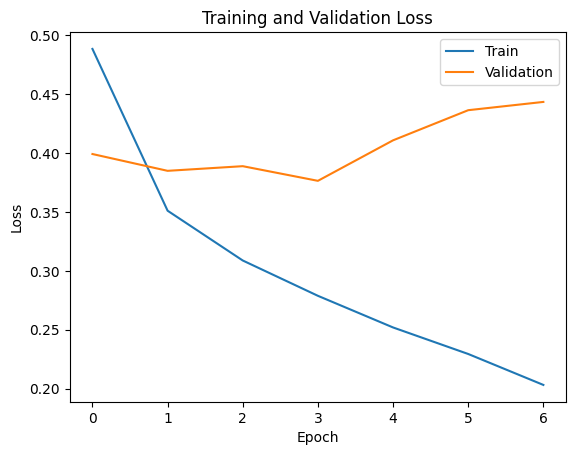

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Model Saving

**TensorFlow Serving**

In [ ]:
# Save the model into SavedModel format
model.save("/content/drive/MyDrive/Model/path_to_saved_model", save_format="tf")

In [ ]:
# Simpan model dalam format SavedModel for Tensor Serving
model.save("/content/drive/MyDrive/Model/TFServing/mental_health_detection_model_serving")

# Download as a ZIP
!zip -r mental_health_detection_model_serving.zip /content/drive/MyDrive/Model/TFServing/mental_health_detection_model_serving

  adding: content/drive/MyDrive/Model/TensorflowServing/mental_health_detection_model_serving/ (stored 0%)
  adding: content/drive/MyDrive/Model/TensorflowServing/mental_health_detection_model_serving/variables/ (stored 0%)
  adding: content/drive/MyDrive/Model/TensorflowServing/mental_health_detection_model_serving/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/drive/MyDrive/Model/TensorflowServing/mental_health_detection_model_serving/variables/variables.index (deflated 64%)
  adding: content/drive/MyDrive/Model/TensorflowServing/mental_health_detection_model_serving/assets/ (stored 0%)
  adding: content/drive/MyDrive/Model/TensorflowServing/mental_health_detection_model_serving/saved_model.pb (deflated 90%)
  adding: content/drive/MyDrive/Model/TensorflowServing/mental_health_detection_model_serving/fingerprint.pb (stored 0%)
  adding: content/drive/MyDrive/Model/TensorflowServing/mental_health_detection_model_serving/keras_metadata.pb (deflated 90%)


**TensorFlow JS**

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalle

In [ ]:
# Save the model in H5 format to save it in TFJS
model.save('/content/drive/MyDrive/Model/TFJS/model.h5', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Convert from h5 to JSON
!tensorflowjs_converter --input_format=keras /content/drive/MyDrive/Model/TFJS/model.h5 /content/drive/MyDrive/Model/TFJS/tfjs_model

2023-12-13 11:44:04.751972: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 11:44:04.752017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 11:44:04.753527: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 11:44:06.291002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# Check the contents of the tfjs folder
!ls /content/drive/MyDrive/Model/TFJS/tfjs_model

group1-shard1of1.bin  model.json


**TensorFlow Lite**

In [ ]:
# Convert the model to TFLite format
converter = lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [lite.OpsSet.TFLITE_BUILTINS, lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False  # Disable experimental lowering of tensor list ops
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = '/content/drive/MyDrive/Model/TFLite/model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f'TFLite model saved to: {tflite_model_path}')

TFLite model saved to: /content/drive/MyDrive/Model/TFLite/model.tflite
